# Reaction Time

In [1]:
import glob 
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd 
import seaborn as sns

from statannotations.Annotator import Annotator


session_palette = {
    session_index + 1: color for session_index, color in enumerate(['#D1D9EC', '#a2b1d8', '#8597c6', '#697fb7', '#ffbcbb', '#ffb5b4', '#ffaeac', '#ffa6a5', '#e44e4b', '#d93f3c', '#cc3330', '#b03533', '#ddde29', '#bcbd21'])
}
figure_folder = 'figures'
os.makedirs(figure_folder, exist_ok=True)

joystick_length = 15
hw = 2048
n_s_per_min = 60
n_ms_per_s = 1000
joystick_threshold = 0.15
n_total_trial = 100

def analog_to_digital(analog, max_joystick_angle=22.5):
    return joystick_length * (np.sin(np.deg2rad(max_joystick_angle * analog/hw)))

reaction_times = []
for subject in ['M15_2', 'M15_3', 'M15_5', 'M15_7', 'M16_1']:
    session_paths = sorted(glob.glob(f'data/raw/controller/**/{subject.replace("_", "-")}.TXT'))

    for session_index, session_path in enumerate(session_paths):
        events = pd.read_csv(session_path)
        # If there are multiple headers that day, the last header marks the start of the actual experiment. This might happen when we use the subject RFID tag duing the equipment check.
        state_ids = np.where(events['state'] == 'state')[0]
        if len(state_ids) > 0:
            events = events.iloc[state_ids[-1]+1:].reset_index(drop=True)
            events['x'] = pd.to_numeric(events['x'])
            events['y'] = pd.to_numeric(events['y'])
            events['time'] = pd.to_numeric(events['time'])
            events['state'] = pd.to_numeric(events['state'])
            events['trial'] = pd.to_numeric(events['trial'])
            events['s_trial'] = pd.to_numeric(events['s_trial'])
            events['f_trial'] = pd.to_numeric(events['f_trial'])

        events['x'] = analog_to_digital(events['x'])
        events['y'] = analog_to_digital(events['y'])
        events['position'] = np.sqrt(events['x'] ** 2 + events['y'] ** 2)
        events['time'] = events['time'] - events['time'][0]
        events['time'] = events['time'] / n_ms_per_s 

        for trial in range(n_total_trial):
            trial_indices = np.where(events['trial'] == trial)[0]
            if any(events['state'][trial_indices] == 1):
                trial_reaction_index = np.where((events['trial'] == trial) & (events['state'] == 1))[0][0]
                reaction_times.append({
                    'subject': subject,
                    'session': session_index+1,
                    'reaction': events['time'][trial_reaction_index] - events['time'][trial_indices.min()],
                })
        
reaction_times = pd.DataFrame(reaction_times)

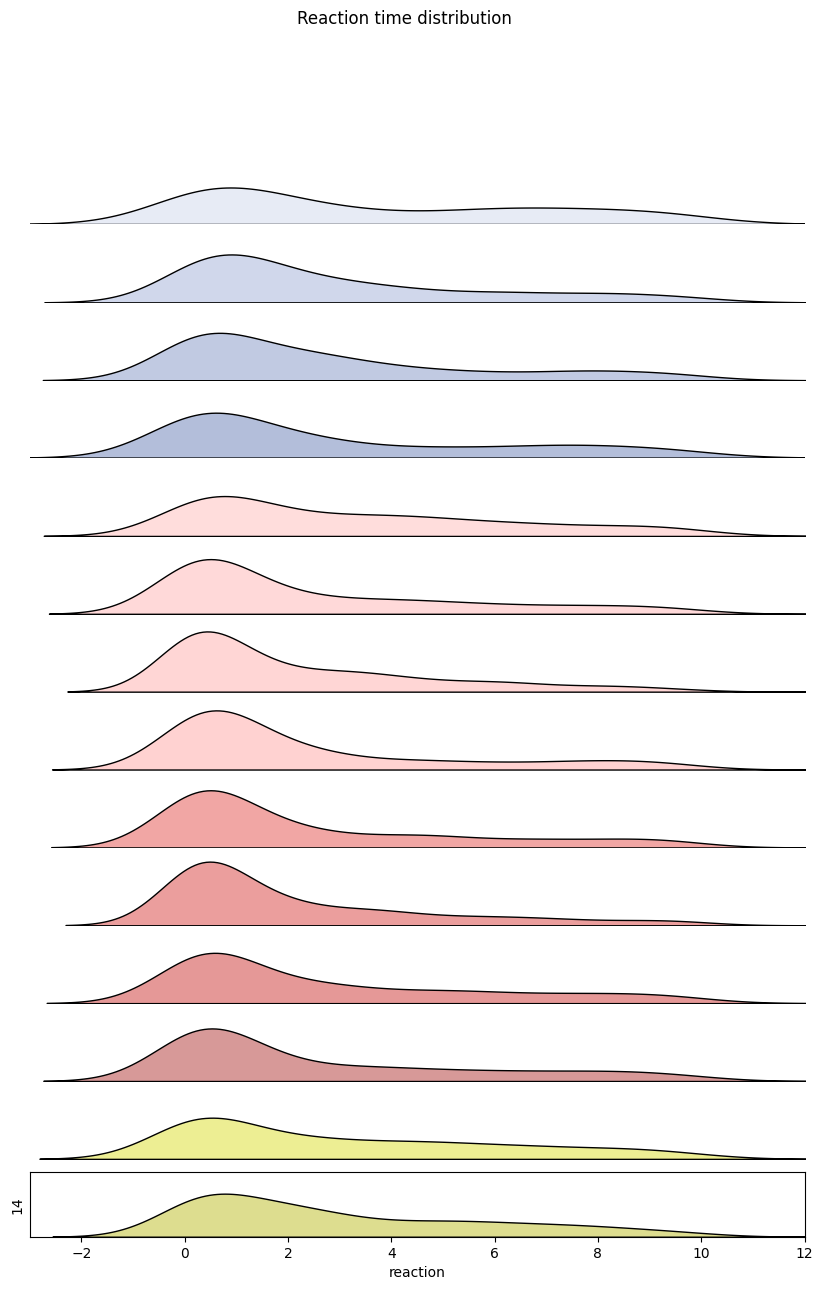

In [2]:
fig = plt.figure(figsize=(10, 15))
for session in range(1, reaction_times['session'].max()+1):
    ax = plt.subplot(len(reaction_times['session'].unique())+1, 1, session)
    sns.kdeplot(data=reaction_times[reaction_times['session']==session], x='reaction', label=f'Session {session+1}', ax=ax, fill=True, color=session_palette[session],edgecolor='black', alpha=0.5)
    ax.set_ylim(0, 0.28)
    ax.set_xlim(-3, 12)
    ax.set_ylabel(session)
    ax.set_yticks([])
    ax.set_axis_off()
ax.set_axis_on()
fig.suptitle(f'Reaction time distribution')
plt.savefig(f'{figure_folder}/reaction_density.pdf')
plt.show()
plt.close()

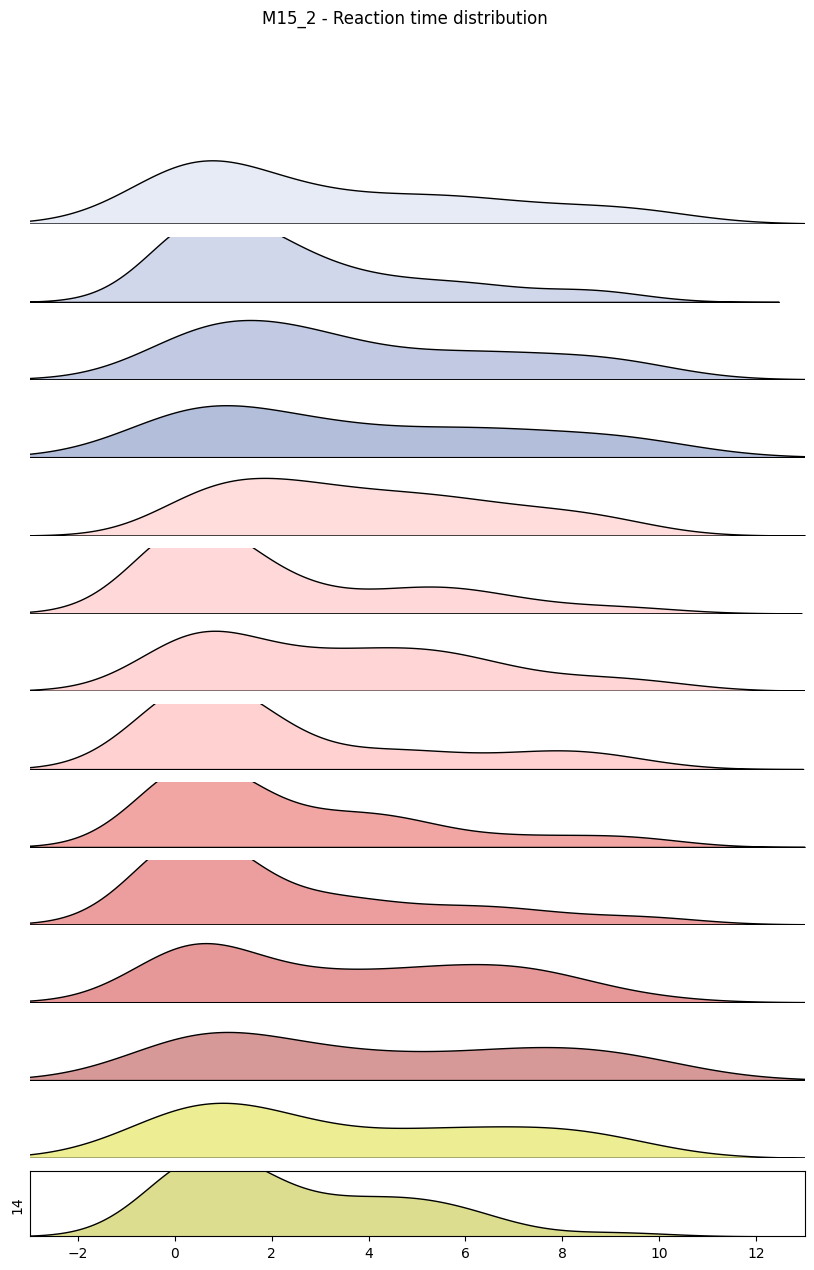

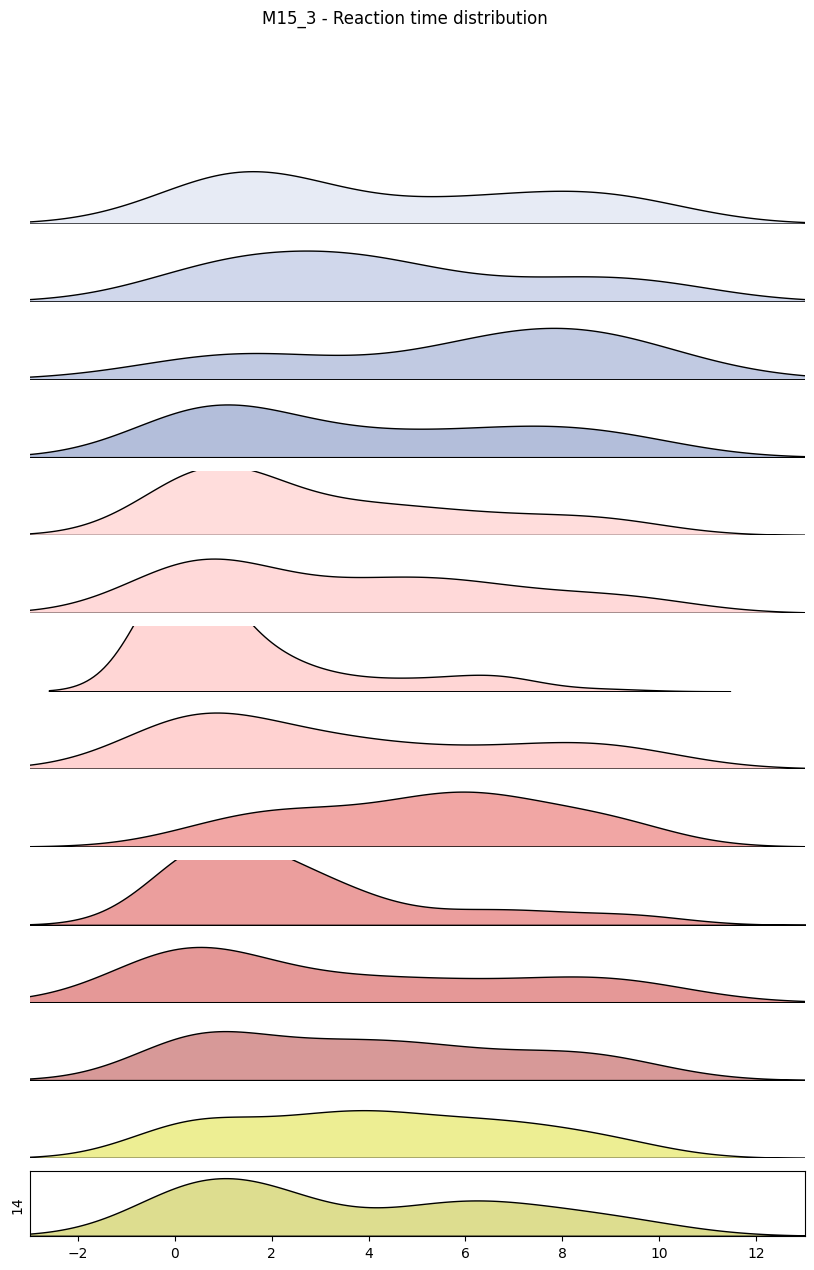

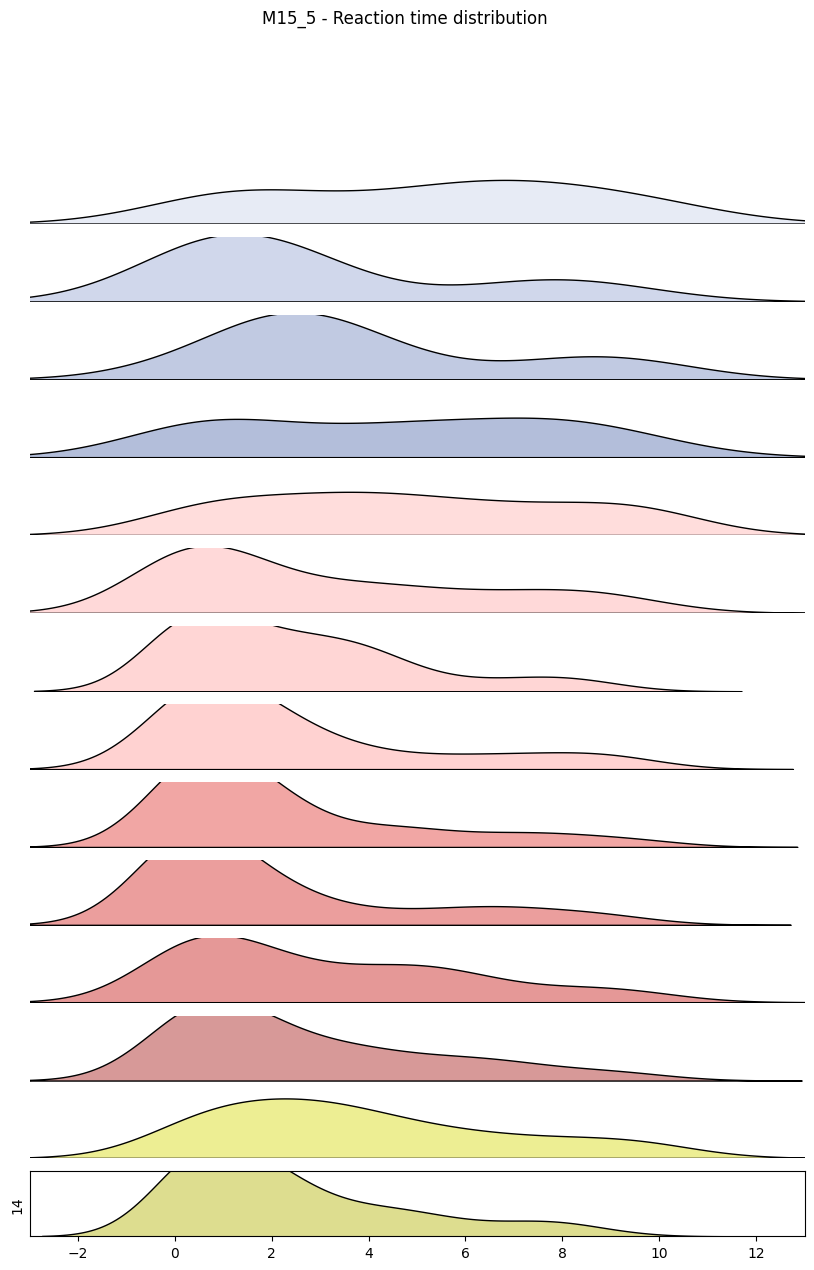

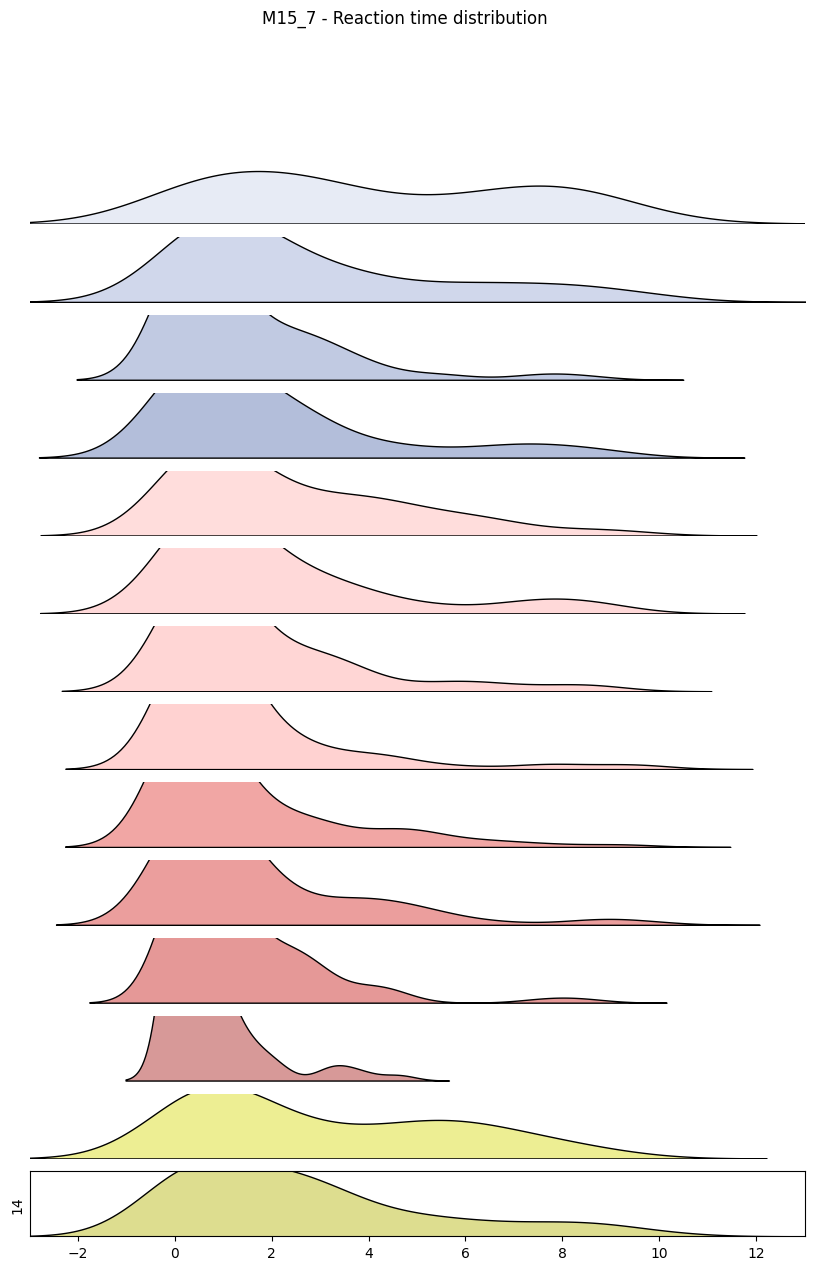

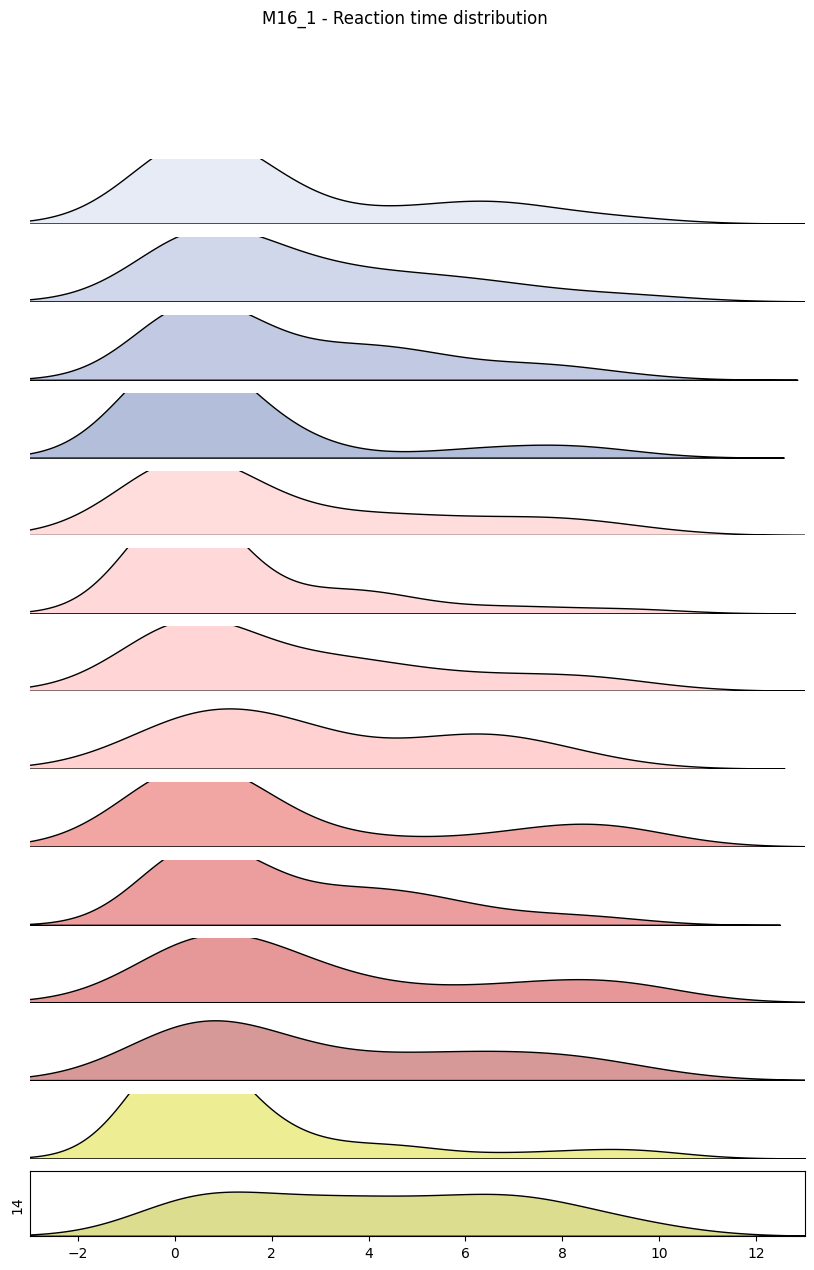

In [3]:
for subject in ['M15_2', 'M15_3', 'M15_5', 'M15_7', 'M16_1']:
    stats = reaction_times[reaction_times['subject']==subject]
    fig = plt.figure(figsize=(10, 15))
    for session in range(1, stats['session'].max()+1):
        ax = plt.subplot(len(stats['session'].unique())+1, 1, session)
        sns.kdeplot(data=stats[stats['session']==session], x='reaction', label=f'Session {session+1}', ax=ax, fill=True, color=session_palette[session],edgecolor='black', alpha=0.5)
        ax.set_ylim(0, 0.15)
        ax.set_xlim(-3, 13)
        ax.set_ylabel(session)
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_axis_off()
    ax.set_axis_on()
    fig.suptitle(f'{subject} - Reaction time distribution')
    plt.savefig(f'{figure_folder}/{subject}_reaction_density.pdf')
    plt.show()
    plt.close()

# Success Rate

In [4]:
import glob 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

joystick_length = 15
hw = 2048
n_s_per_min = 60
n_ms_per_s = 1000
joystick_threshold = 0.15
n_total_trial = 100

def analog_to_digital(analog, max_joystick_angle=22.5):
    return joystick_length * (np.sin(np.deg2rad(max_joystick_angle * analog/hw)))

half_successes = []
successes = []
for subject in ['M15_2', 'M15_3', 'M15_5', 'M15_7', 'M16_1']:
    session_paths = sorted(glob.glob(f'data/raw/controller/**/{subject.replace("_", "-")}.TXT'))
    for session_index, session_path in enumerate(session_paths):
        events = pd.read_csv(session_path)
        half_successes.append({
            'rate': events['s_trial'].tolist()[np.where(events['trial'] == (n_total_trial//2))[0][-1]]/(n_total_trial//2),
            'subject': subject,
            'session': session_index+1,
        })
        successes.append({
            'rate': events['s_trial'].tolist()[-1]/n_total_trial,
            'subject': subject,
            'session': session_index+1,
        })
half_successes = pd.json_normalize(half_successes)
successes = pd.json_normalize(successes)

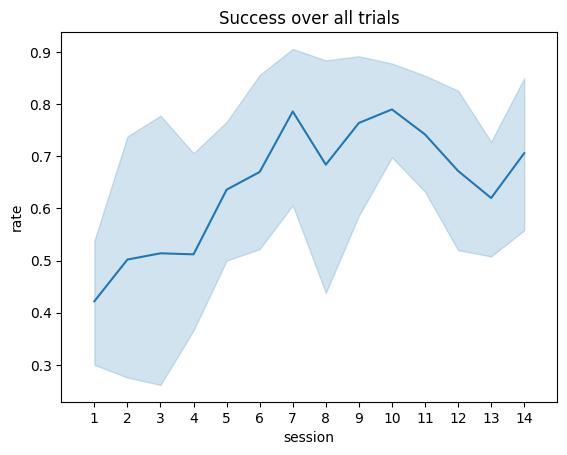

In [7]:
plt.figure()
sns.lineplot(data=successes, x='session', y='rate')#, hue='subject')
plt.title('Success over all trials')
plt.xlim(0, 15)
plt.xticks(np.arange(1, 15))
plt.savefig(f'{figure_folder}/rate_line.pdf')
plt.show()
plt.close()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

1 vs. 6: Welch's t-test independent samples, P_val:8.960e-02 t=-1.968e+00
1 vs. 10: Welch's t-test independent samples, P_val:3.782e-03 t=-4.134e+00
1 vs. 14: Welch's t-test independent samples, P_val:3.899e-02 t=-2.491e+00


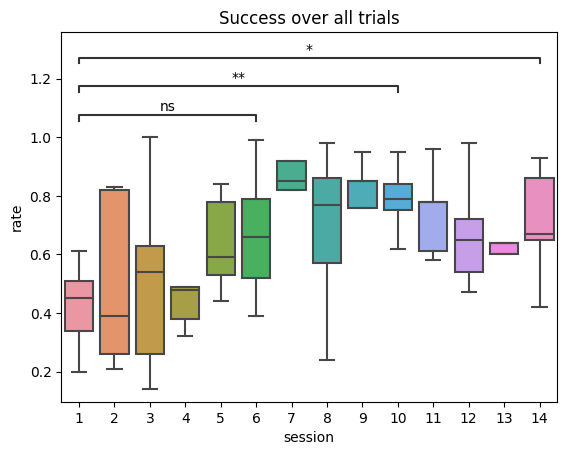

In [8]:
plt.figure()
ax = plt.gca()
sns.boxplot(data=successes, x='session', y='rate', showfliers=False, ax=ax)#, hue='subject')
plt.title('Success over all trials')
pairs = [(1, 6), (1, 10), (1, 14)]
annotator = Annotator(ax, pairs, data=successes, x='session', y='rate')
annotator.configure(test="t-test_welch").apply_and_annotate()
plt.savefig(f'{figure_folder}/rate_box.pdf')
plt.show()
plt.close()

# Firing Heatmap

In [42]:
np.arange(-s_before_cue, s_after_cue, 0.1)

array([-1.00000000e+00, -9.00000000e-01, -8.00000000e-01, -7.00000000e-01,
       -6.00000000e-01, -5.00000000e-01, -4.00000000e-01, -3.00000000e-01,
       -2.00000000e-01, -1.00000000e-01, -2.22044605e-16,  1.00000000e-01,
        2.00000000e-01,  3.00000000e-01,  4.00000000e-01,  5.00000000e-01,
        6.00000000e-01,  7.00000000e-01,  8.00000000e-01,  9.00000000e-01,
        1.00000000e+00,  1.10000000e+00,  1.20000000e+00,  1.30000000e+00,
        1.40000000e+00,  1.50000000e+00,  1.60000000e+00,  1.70000000e+00,
        1.80000000e+00,  1.90000000e+00])